<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/03_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80_(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Предсказание стоимости квартир (DNN)**

# 1 Постановка задачи

Необходимо подготовить нейронную сеть, предназначенную для предсказания стоимости квартир на основе сведений о них.

Требуется:
- загрузить xTrain на числовых данных;
- загрузить xTrainС из "Примечаний" (тексты);
- создать словарь;
- превратить xTrainC в формат bag of words (2000 самых популярных слов);
- сделать нормирование данных;
- написать нейронную сеть.

# 2 Подгрузка библиотек и подключение диска

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
#import os #Для работы с файлами
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Подгрузка базы

In [ ]:
df = pd.read_csv('/content/drive/My Drive/HW_19/moscow.csv', sep=";") #Загружаем данные в data frame
df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array

In [ ]:
df.head() #Показываем пример данных (первые 6 колонок)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...


In [ ]:
print(df.columns) #Показываем имена колонок данных
#Мы будем использовать

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


# 4 Парсинг базы

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount):
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0

  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро

  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс

  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]

  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3

  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку

  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте

  #Еcли строка не равна nan
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0

  #Число классов дистанции
  metroDistanceClasses = 7

  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14

  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""

  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа

  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):

      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr):
          houseType = 1
        if ("К" in houseTypeStr):
          houseType = 2
        if ("П" in houseTypeStr):
          houseType = 3
        if ("Б" in houseTypeStr):
          houseType = 4
        if ("?" in houseTypeStr):
          houseType = 5
        if ("-" in houseTypeStr):
          houseType = 6

    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)


  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)

  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)

  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади

  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0

  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку

  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0

  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки

  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)

  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):

  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())

  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)

  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):

  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data]
  yTrain = np.array(costList)

  return yTrain

# 5 Формирование обучающих выборок № 1

In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
type(xTrain)

numpy.ndarray

In [ ]:
print(xTrain.shape)

(62504, 109)


# 6 Формирование обычающих выборок № 2

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр


  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами

  #идём по всем символам
  for symbol in text:

    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""):
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)

  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):

  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []

  #Идём по всем словая
  for word in words:

    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре

    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0

    wordsIndexes.append(wordIndex)

  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)

  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1

  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []

  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words

  return np.array(out)

Формирование xTrain из столбца "Примечание"

In [ ]:
###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря

  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try:
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку

  xTrainComments = np.array(xTrainComments)

  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов

  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain

  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов

  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain

  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большо текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


# 7 Нормирование данных

In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler()                  # Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1))    # Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() # Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
# Нормируем выход сети - цену квартиры
yScaler = StandardScaler()                                 # Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1))                         # Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))    # Нормируем цены квартир

# Выводим размер и два примера для сравнения
# Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


Формирование проверочной выборки

In [ ]:
splitVal = 0.2                                                  # Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal    # Создаём маску True-False для создания проверочной выборки

# 8 Создание и обучение составной нейорнной сети

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])             # Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten()                      # Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   # Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled                                         # Считаем разность предсказания и правильных цен
  absDelta = abs(delta)                                                         # Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) # Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха 0 модуль ошибки 2.059
Эпоха 1 модуль ошибки 2.065
Эпоха 2 модуль ошибки 1.548
Эпоха 3 модуль ошибки 1.533
Эпоха 4 модуль ошибки 1.186
Эпоха 5 модуль ошибки 1.33
Эпоха 6 модуль ошибки 1.136
Эпоха 7 модуль ошибки 1.516
Эпоха 8 модуль ошибки 1.233
Эпоха 9 модуль ошибки 1.137
Эпоха 10 модуль ошибки 1.062
Эпоха 11 модуль ошибки 1.139
Эпоха 12 модуль ошибки 1.213
Эпоха 13 модуль ошибки 1.153
Эпоха 14 модуль ошибки 1.032
Эпоха 15 модуль ошибки 1.018
Эпоха 16 модуль ошибки 1.079
Эпоха 17 модуль ошибки 1.355
Эпоха 18 модуль ошибки 1.017
Эпоха 19 модуль ошибки 1.021
Эпоха 20 модуль ошибки 1.048
Эпоха 21 модуль ошибки 1.11
Эпоха 22 модуль ошибки 1.015
Эпоха 23 модуль ошибки 1.027
Эпоха 24 модуль ошибки 0.994
Эпоха 25 модуль ошибки 0.985
Эпоха 26 модуль ошибки 1.085
Эпоха 27 модуль ошибки 1.025
Эпоха 28 модуль ошибки 1.046
Эпоха 29 модуль ошибки 1.058
Эпоха 30 модуль ошибки 0.966
Эпоха 31 модуль ошибки 1.043
Эпоха 32 модуль ошибки 0.963
Эпоха 33 модуль ошибки 0.994
Эпоха 34 модуль ошибки 1.0

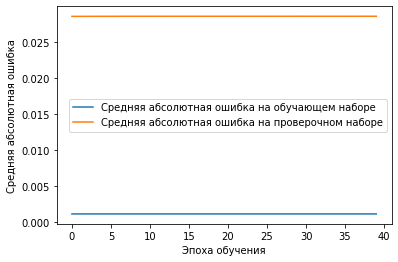

In [ ]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])



print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-6')
model.compile(optimizer=Adam(lr=1e-6), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-7')
model.compile(optimizer=Adam(lr=1e-7), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])             # Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten()                      # Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   # Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled                                         # Считаем разность предсказания и правильных цен
absDelta = abs(delta)                                                         # Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta)))                # Выводим усреднённую ошибку в миллионах рублей

#Выводим графики ошибки
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# 9 Выводы

Разработана нейронная сеть с двумя входами, включающая в свой состав Dense-слои, состояие из:
- 10 нейронов в первой ветке и 250 нейроно во второй ветке 1-го первого слоя;
- 100 нейронов во 2-м слое, объединяющим две ветки;
- 10 нейронов в 3-м слое;
- 1 нейрон в выходном слое.

Созданная нейронная сеть была обучена на 200 эпохах. Каждые 40 эпох шаг обучения увеличивался, начиная со значения 1e-3 и заканчивая значением 1e-7. При значени шага обучения 1e-5 (примерно 83-я эпоха) значение ошибки зафиксировалось в диапазоне 0,849 - 0,850.

Таким образом, при выбранных параметрах нейронной сети установка значения шага обучения менее 1e-5 нецелесообразна.